## imports

In [1]:
import os
import re
import nltk
import html2text
import markdown
import numpy as np
import pandas as pd
import brainiak.eventseg.event as event
import hypertools.tools.format_data as fit_transform
from num2words import num2words
from bs4 import BeautifulSoup
from downloader import download_file_from_google_drive as dl

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
nltk.download('stopwords')
from nltk.corpus import stopwords as sw

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/paxtonfitzpatrick/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### topic modeling parameters

In [3]:
n_topics = 100
video_wsize = 50 # sentences 

# vectorizer parameters
vectorizer_params = {
    'model' : 'CountVectorizer', 
    'params' : {
        'stop_words' : sw.words('english')
    }
}

# topic model parameters
semantic_params = {
    'model' : 'LatentDirichletAllocation', 
    'params' : {
        'n_components' : n_topics,
        'learning_method' : 'batch',
        'random_state' : 0,
    }
}

## functions

In [4]:
def wipe_formatting(script, rehtml=False):
    parser = html2text.HTML2Text()
    parser.wrap_links = True
    parser.skip_internal_links = True
    parser.inline_links = True
    parser.ignore_anchors = True
    parser.ignore_images = True
    parser.ignore_emphasis = True
    parser.ignore_links = True
    text = parser.handle(script)
    text = text.strip(' \t\n\r')
    if rehtml:
        text = text.replace('\n', '<br/>')
        text = text.replace('\\', '')
    md = markdown.markdown(text)
    soup=BeautifulSoup(md,'html5lib')
    soup=soup.get_text()
    soup = soup.replace('\n', ' ')
    return soup

In [5]:
def load_data(filepath, fileid):
    data_dir = os.path.dirname(filepath)
    
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    if not os.path.exists(filepath):
        print('downloading data...')
        dl(fileid, filepath)
        
    print('loading data...')
    data = pd.read_csv(filepath)
    return data.dropna(subset=['script'])

In [24]:
def cleanup_text(transcript):
    lower_nopunc = re.sub("[^\w\s.]+", '', transcript.lower())    # remove all punctuation except periods (deliminers)
    no_digit = re.sub(r"(\d+)", lambda x: num2words(int(x.group(0))), lower_nopunc)    # convert digits to words
    spaced = ' '.join(no_digit.replace(',', ' ').split())    # deal with inconsistent whitespace
    return spaced

In [46]:
def get_windows(transcript, wsize=video_wsize):
    cleaned = cleanup_text(wipe_formatting(transcript))
    text_list = cleaned.split('.')
    video_w = []
    
    for ix, sentence in enumerate(text_list):
        video_w.append(' '.join(text_list[ix:ix+wsize]))
        
    return video_w

In [76]:
def topic_model(transcript, vec_params=vectorizer_params, sem_params=semantic_params, return_windows=False):
    windows = get_windows(transcript)
    # handle movies with missing or useless transcripts
    if len(windows) < 10:
        return np.nan
    
    traj = fit_transform(windows, vectorizer=vec_params, semantic=sem_params, corpus=windows)[0]
    
    if return_windows:
        return traj, windows
    else:
        return traj

In [123]:
def optimize_k(trajectory, ks_list):
    corrmat = np.corrcoef(trajectory)
    scores = []
    
    for k in ks_list:
        ev = event.EventSegment(k)
        ev.fit(trajectory)
        w = np.round(ev.segments_[0]).astype(int)
        mask = np.sum(list(map(lambda x: np.outer(x, x), w.T)), 0).astype(bool)
        within = corrmat[mask].mean()
        across = corrmat[~mask].mean()
        scores.append((within, across))
        
    t = list(map(lambda x: x[0]/(x[1]-(scores[0][0]/scores[0][1])), scores))
    t /= np.max(t)
    ratios = list(map(lambda x: x - k/(5*video_wsize), t))
    return ks_list[np.argmax(ratios)]

In [162]:
def segment_trajectory(traj, k):
    ev = event.EventSegment(k)
    ev.fit(traj)
    w = (np.round(ev.segments_[0])==1).astype(bool)
    segs = np.array([traj[wi, :].mean(0) for wi in w.T])
    event_times = []
    for s in ev.segments_[0].T:
        tp = np.where(np.round(s)==1)[0]
        event_times.append((tp[0], tp[-1]))
        
    return segs, event_times

In [12]:
def tm_handle_bad(transcript, **kwargs):
    try:
        return topic_model(transcript, **kwargs)
    # just catch all errors, nearly all data passes
    # often IndexError due to script being all newlines
    except:
        return np.nan

# main code

In [132]:
data_filepath = '../data/data.csv'
data_fileID = '1hCCn31z4HM4IzQi59DP-vvUpYKhlvo2S'
# possible numbers of events to try for each transcript
ks_list = list(range(2, 51))

# download and load data
data_df = load_data(data_filepath, fileid=data_fileID)

loading data...


In [133]:
data_df = data_df[:3]

In [134]:
# fit topic model, transform script
data_df['trajectory'] = data_df.script.apply(tm_handle_bad)

In [136]:
data_df = data_df.dropna()

In [138]:
# determine number of events for segmentation
data_df['n_events'] = data_df.trajectory.apply(optimize_k, ks_list=ks_list)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


/Users/paxtonfitzpatrick/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0.5,0,'Number of events (k)')

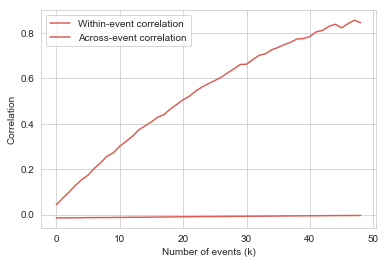

In [147]:
plt.plot(list(map(lambda x: x[0], scores)), label='Within-event correlation')
plt.plot(list(map(lambda x: x[1], scores)), label='Across-event correlation')
plt.legend()
plt.ylabel('Correlation')
plt.xlabel('Number of events (k)')

In [148]:
scores

[(0.04290213198056462, -0.014779459925506945),
 (0.07156369846011361, -0.014543652074382364),
 (0.09878287286760853, -0.014315412468220684),
 (0.1278909000458543, -0.014394613231778063),
 (0.15374288540736925, -0.013912086657378206),
 (0.17361056394330096, -0.013524163361846182),
 (0.20375463603681487, -0.013525271939540444),
 (0.22867925609587908, -0.013061558586150287),
 (0.25700205748342775, -0.013153382219467765),
 (0.2722901542403843, -0.012617027997388851),
 (0.30098079853068804, -0.012649644903612674),
 (0.32214312432565045, -0.012271264058134026),
 (0.3444050941195172, -0.011869281914679387),
 (0.37303100575908493, -0.0118422390771497),
 (0.3906457637307191, -0.011421398061939914),
 (0.4084323369354072, -0.01118518140591274),
 (0.42893837178808325, -0.010982739557794533),
 (0.440840392101024, -0.010504661178943346),
 (0.46574876685837796, -0.010506919592269617),
 (0.4849967643257479, -0.010157936000070707),
 (0.5059138483450132, -0.009861627916567193),
 (0.5217044918375758, -0.

In [149]:
t = list(map(lambda x: x[0]/(x[1]-(scores[0][0]/scores[0][1])), scores))
t /= np.max(t)
ratios = list(map(lambda x: x - k/(5*video_wsize), t))

Text(0.5,0,'Number of events (k)')

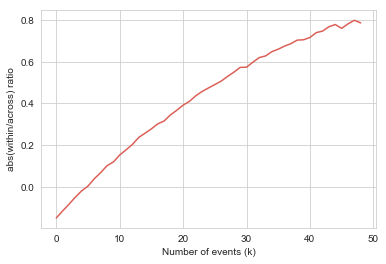

In [150]:
plt.plot(ratios, label='Within-event correlation')
plt.ylabel('abs(within/across) ratio')
plt.xlabel('Number of events (k)')

In [164]:
# segment trajectory based on that number
data_df[['segments', 'event onsets/offsets']] = data_df.apply(lambda x: 
                                                              segment_trajectory(x['trajectory'], x['n_events']), 
                                                              result_type='expand', axis=1)

/Users/paxtonfitzpatrick/anaconda/envs/py36/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
